In [319]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
from datetime import datetime

In [320]:
current_month = datetime.today().month
current_year = datetime.today().year
month_mapping = {1:'jan', 
                 2:'feb',
                 3:'mar', 
                 4:'apr', 
                 5:'may', 
                 6:'jun', 
                 7:'jul', 
                 8:'aug', 
                 9:'sep', 
                 10:'oct', 
                 11:'nov', 
                 12:'dec'}
months = list(month_mapping.values())
current_month_name = month_mapping[current_month]

In [321]:
LOAD_DIR = Path(Path.cwd(), "data")
fnames = ["rainfall.txt", "sunshine.txt", "tmax.txt", "tmean.txt", "tmin.txt"]
titles = ['Rainfall', 'Sunshine', 'Max Temp', 'Mean Temp', 'Min Temp']
raw_data_dict = {}
for fname in fnames:
    with open (Path(LOAD_DIR, fname)) as f:
        data = (f.readlines()[5:])
    raw_data_dict[fname[:-4]] = data

In [322]:
raw_data_dict['rainfall'][:10]

['year    jan    feb    mar    apr    may    jun    jul    aug    sep    oct    nov    dec     win     spr     sum     aut     ann\n',
 '1836  101.5   69.8  122.2   75.1   13.8   76.5  109.2   63.1  113.2  120.8  150.0  108.6     ---   211.1   248.8   384.1  1123.8\n',
 '1837   79.5  104.7   36.2   54.1   39.9   57.9   87.5   90.7   67.5   97.0   97.8   96.0   292.8   130.2   236.1   262.3   908.9\n',
 '1838   35.4   55.5   69.4   57.1   61.8  117.8   84.2   92.8   74.9   93.7  120.5   74.3   186.9   188.3   294.9   289.1   937.4\n',
 '1839   75.7   67.2   83.1   38.4   35.5   93.7  118.5   84.3  145.1  102.1  116.0  103.9   217.2   157.0   296.5   363.3  1063.6\n',
 '1840  124.6   67.9   14.2   23.2   83.6   68.6   90.3   78.0  106.1   65.9  126.3   41.0   296.5   121.0   237.0   298.3   889.8\n',
 '1841   80.0   58.6   74.3   56.6   70.4   70.1   91.2  118.0  118.6  151.4  108.5  123.7   179.6   201.2   279.4   378.5  1121.4\n',
 '1842   77.9   68.4  110.9   11.2   65.8   63.1   77.9

In [323]:
dfs = []
for name, data in raw_data_dict.items():
    lst_lsts = []
    for i in range(len(data)):
        _temp = data[i].split(" ")
        lst_lsts.append([i for i in _temp if i])
    df = pd.DataFrame(lst_lsts)
    dfs.append(df)

In [324]:
dfs_dict = dict(zip(titles, dfs))

In [325]:
def clean_df(raw_df:pd.DataFrame) -> pd.DataFrame:
    raw_df.columns = raw_df.iloc[0]
    df = raw_df[1:]
    df = df.replace(to_replace = ["---","\n", None], value = np.nan)
    df['ann'] = df['ann\n'].str.replace("\n", "")
    df = df.drop('ann\n', axis = 1, errors = 'ignore')
    df = df.apply(pd.to_numeric)
    df = df.drop(['win', 'spr', 'sum', 'aut', 'ann'], axis = 1, errors = 'ignore')
    return df

dfs_dict = {k:clean_df(v) for k,v in dfs_dict.items()}

In [326]:
def overwrite_months_to_come(df:pd.DataFrame) -> pd.DataFrame:
    # overwriting months not yet occured
    months_to_overwrite = []
    for i in range(current_month, 13):
        months_to_overwrite.append(month_mapping[i])
    for month in months_to_overwrite:
        df.loc[df['year'] == current_year, month] = np.nan
    return df

In [327]:
dfs_dict = {k:overwrite_months_to_come(v) for k,v in dfs_dict.items()}

In [328]:
months = dfs_dict['Rainfall'].drop('year', axis = 1).columns.to_list()

In [329]:
def generate_deciles(df:pd.DataFrame) -> pd.DataFrame:
    decile_0 = df[months].min()
    decile_10 = df[months].quantile(0.1)
    decile_50 = df[months].quantile(0.5)
    decile_90 = df[months].quantile(0.9)
    decile_100 = df[months].max()
    df_deciles = pd.concat([decile_0, decile_10, decile_50, decile_90, decile_100], axis = 1)
    df_deciles = df_deciles.rename_axis('month')
    return df_deciles

In [330]:
dfs_deciles_dict = {k:generate_deciles(v) for k,v in dfs_dict.items()}

In [331]:
dfs_2023_dict = {}
for k,v in dfs_dict.items():   
    df_2023 = v[v['year'] == 2023].drop('year', axis = 1)
    dfs_2023_dict[k] = df_2023

In [332]:
def point_style(val, month, deciles_df):
    _min = deciles_df[deciles_df.index==month][0.0].values[0]
    _0_1 = deciles_df[deciles_df.index==month][0.1].values[0]
    _0_5 = deciles_df[deciles_df.index==month][0.5].values[0]
    _0_9 = deciles_df[deciles_df.index==month][0.9].values[0]
    _max = deciles_df[deciles_df.index==month][1.0].values[0]
    if _min <= val <= _0_1:
        return "^"
    elif _0_1 <= val <= _0_5:
        return "h"
    elif _0_5 <= val <= _0_9:
        return "o"
    elif _0_9 <= val <= _max:
        return "D"
    else:
        return np.nan
    

In [335]:
def generate_plot(deciles_df:pd.DataFrame,df_2023:pd.DataFrame, **kwargs) -> None:
    title = kwargs['title']
    ylabel = kwargs['ylabel']
    fig, ax = plt.subplots(figsize = (12,8))
    ax.plot(deciles_df.index, deciles_df[0.0], c = 'firebrick')
    ax.plot(deciles_df.index, deciles_df[0.1],  c = 'firebrick', ls = '--')
    ax.plot(deciles_df.index, deciles_df[0.5], c = 'grey')
    ax.plot(deciles_df.index, deciles_df[0.9],  c = 'seagreen', ls = '--')
    ax.plot(deciles_df.index, deciles_df[1.0],  c = 'seagreen')
    for month in df_2023.columns:
        if month not in months_to_overwrite:
            val = df_2023[month].values[0]
            ms = point_style(val, month, deciles_df)
            ax.scatter(month,val, marker = ms, c = 'black', zorder =5)

    ax.set_ylabel(ylabel)
    ax.set_title(title)

In [336]:
titles = ['Rainfall', 'Sunshine', 'Max Temp', 'Mean Temp', 'Min Temp']
ylabels = ['mm', 'hrs', 'Temp (C)', 'Temp (C)', 'Temp (C)']

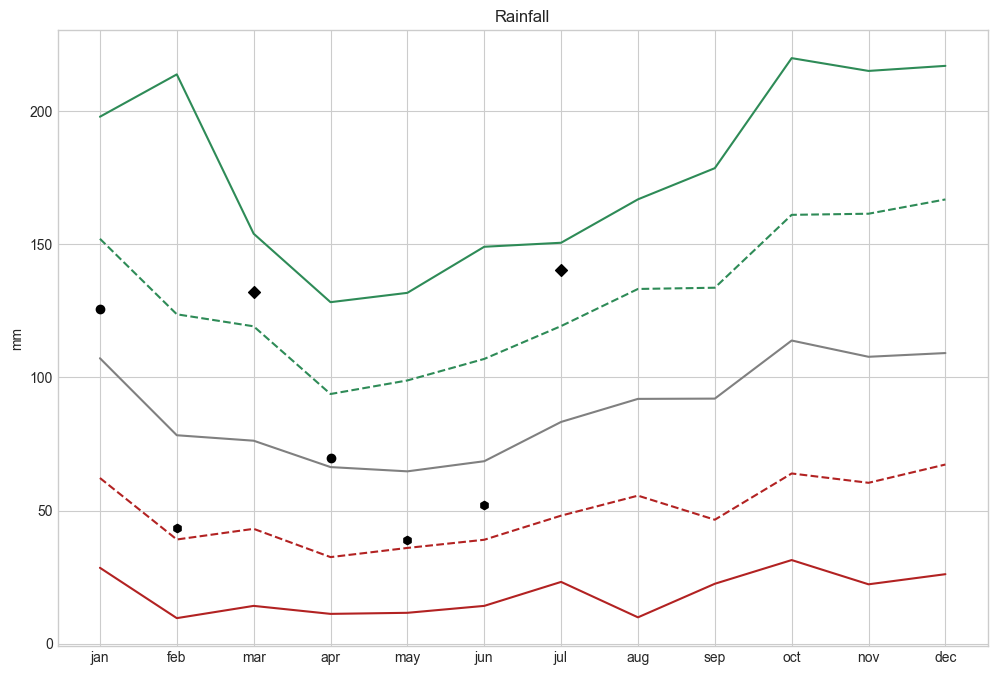

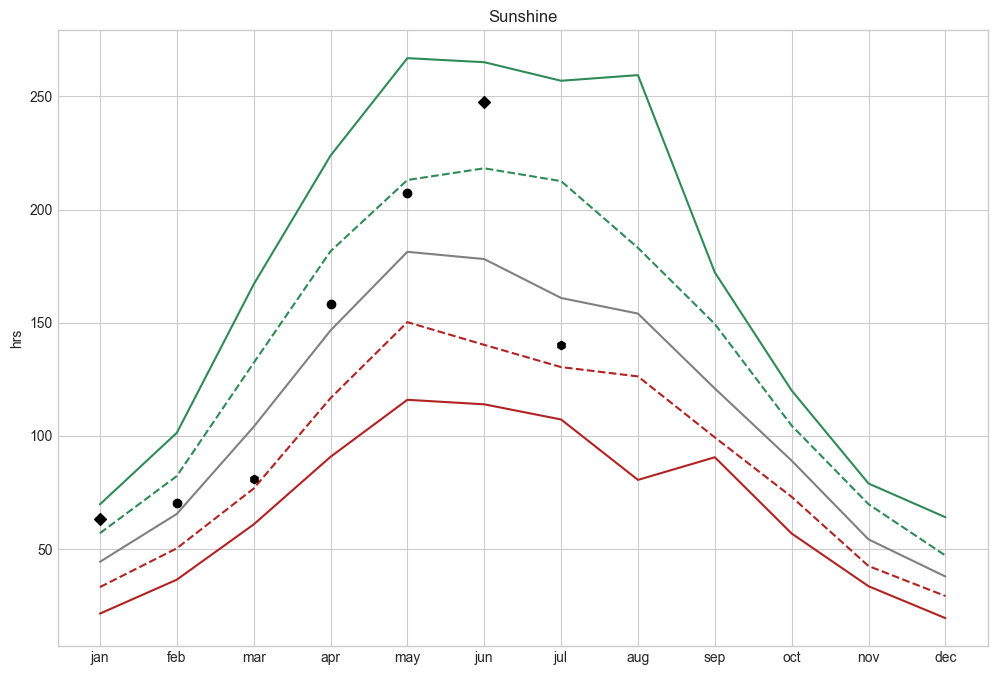

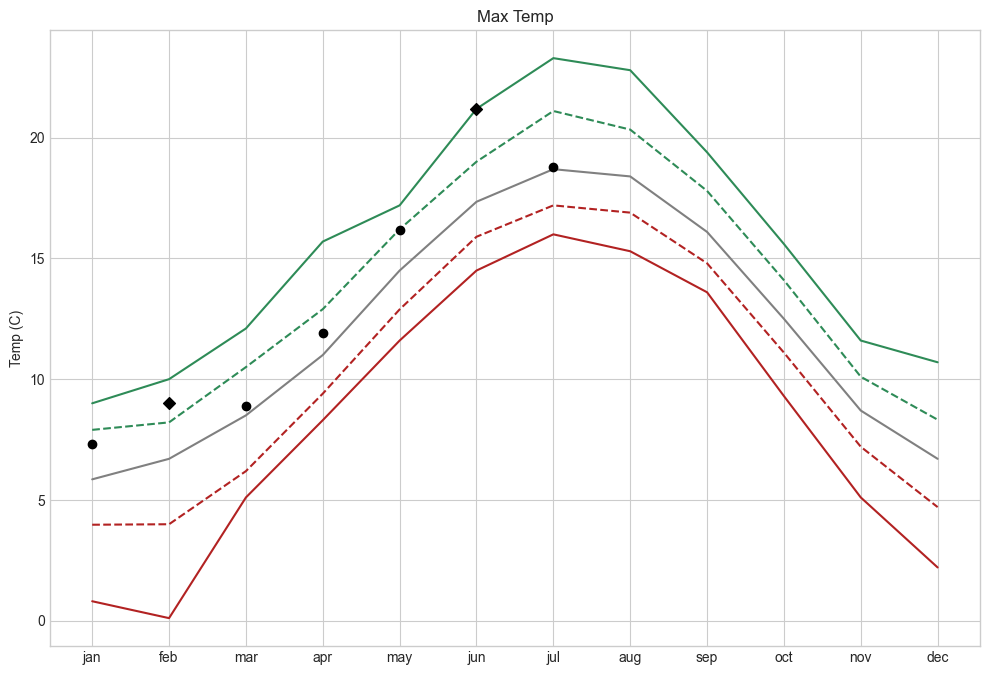

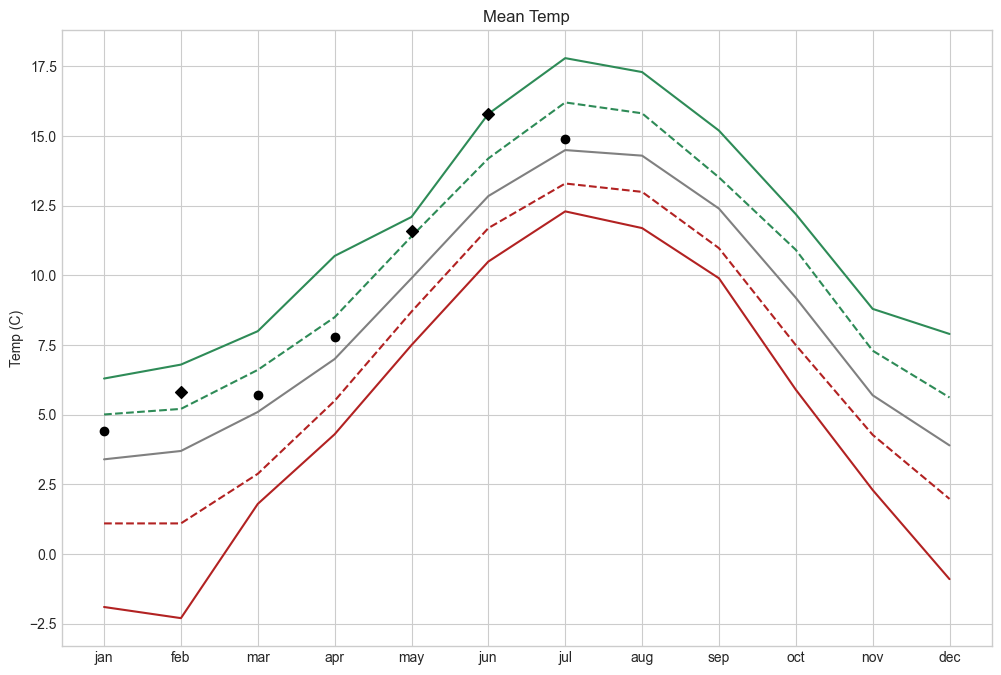

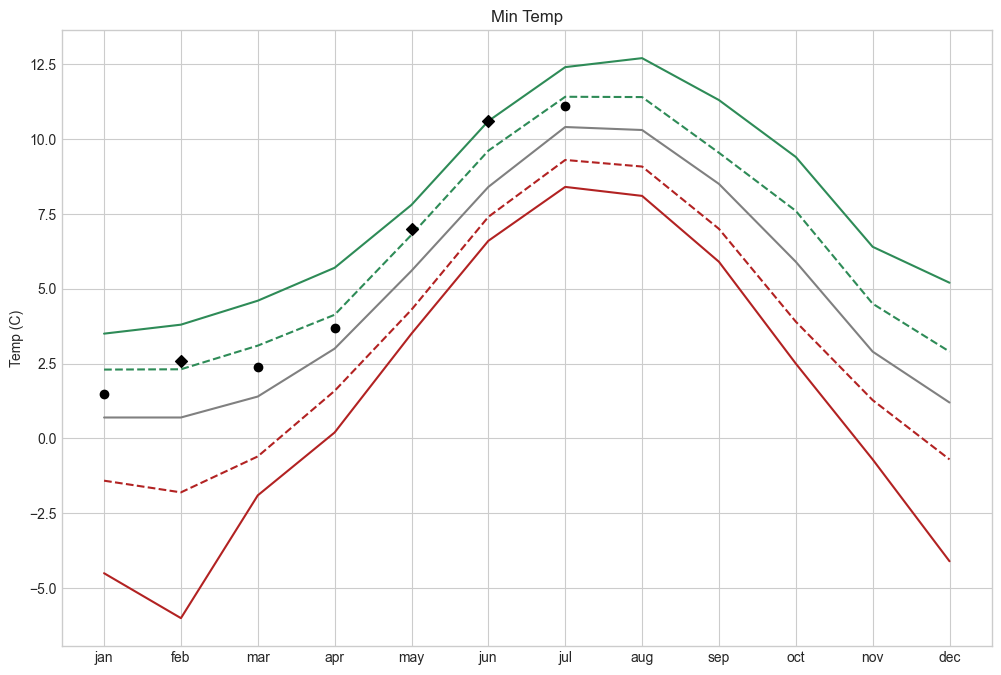

In [342]:
for df_decile, df_2023, title, ylabel in zip(dfs_deciles_dict.values(), dfs_2023_dict.values(), titles, ylabels):
    generate_plot(df_decile, df_2023, title = title, ylabel = ylabel)